### Visual Representation

<img src="../images/reliable_rag.svg" alt="Reliable-RAG" width="300">

# Package Installation and Imports

The cell below installs all necessary packages required to run this notebook.


In [ ]:
# Install required packages
!pip install langchain langchain-community python-dotenv

In [1]:
### LLMs
import os
from dotenv import load_dotenv

# Load environment variables from '.env' file
load_dotenv()

os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY') # For LLM -- llama-3.1-8b (small) & mixtral-8x7b-32768 (large)
os.environ['COHERE_API_KEY'] = os.getenv('COHERE_API_KEY') # For embedding

### Create Vectorstore

In [2]:
### Build Index
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_cohere import CohereEmbeddings

# Set embeddings
embedding_model = CohereEmbeddings(model="embed-english-v3.0")

# Docs to index
urls = [
    "https://www.deeplearning.ai/the-batch/how-agents-can-improve-llm-performance/?ref=dl-staging-website.ghost.io",
    "https://www.deeplearning.ai/the-batch/agentic-design-patterns-part-2-reflection/?ref=dl-staging-website.ghost.io",
    "https://www.deeplearning.ai/the-batch/agentic-design-patterns-part-3-tool-use/?ref=dl-staging-website.ghost.io",
    "https://www.deeplearning.ai/the-batch/agentic-design-patterns-part-4-planning/?ref=dl-staging-website.ghost.io",
    "https://www.deeplearning.ai/the-batch/agentic-design-patterns-part-5-multi-agent-collaboration/?ref=dl-staging-website.ghost.io"
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorstore
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag",
    embedding=embedding_model,
)

retriever = vectorstore.as_retriever(
                search_type="similarity",
                search_kwargs={'k': 4}, # number of documents to retrieve
            )

### Question

In [3]:
question = "what are the differnt kind of agentic design patterns?"

### Retrieve docs

In [4]:
docs = retriever.invoke(question)

### Check what our doc looklike

In [5]:
print(f"Title: {docs[0].metadata['title']}\n\nSource: {docs[0].metadata['source']}\n\nContent: {docs[0].page_content}\n")

Title: Agentic Design Patterns Part 5, Multi-Agent Collaboration

Source: https://www.deeplearning.ai/the-batch/agentic-design-patterns-part-5-multi-agent-collaboration/?ref=dl-staging-website.ghost.io

Content: mature patterns of Reflection and Tool Use are more reliable. I hope you enjoy playing with these agentic design patterns and that they produce amazing results for you! If you're interested in learning more, I recommend: ‚ÄúCommunicative Agents for Software Development,‚Äù Qian et al. (2023) (the ChatDev paper)‚ÄúAutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation,‚Äù Wu et al. (2023) ‚ÄúMetaGPT: Meta Programming for a Multi-Agent Collaborative Framework,‚Äù Hong et al. (2023)Keep learning!AndrewRead "Agentic Design Patterns Part 1: Four AI agent strategies that improve GPT-4 and GPT-3.5 performance"Read "Agentic Design Patterns Part 2: Reflection" Read "Agentic Design Patterns Part 3: Tool Use"Read "Agentic Design Patterns Part 4: Planning" ShareSubscribe 

### Check document relevancy

In [6]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatGroq(model="llama-3.1-8b-instant", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

### Filter out the non-relevant docs

In [7]:
docs_to_use = []
for doc in docs:
    print(doc.page_content, '\n', '-'*50)
    res = retrieval_grader.invoke({"question": question, "document": doc.page_content})
    print(res,'\n')
    if res.binary_score == 'yes':
        docs_to_use.append(doc)

mature patterns of Reflection and Tool Use are more reliable. I hope you enjoy playing with these agentic design patterns and that they produce amazing results for you! If you're interested in learning more, I recommend: ‚ÄúCommunicative Agents for Software Development,‚Äù Qian et al. (2023) (the ChatDev paper)‚ÄúAutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation,‚Äù Wu et al. (2023) ‚ÄúMetaGPT: Meta Programming for a Multi-Agent Collaborative Framework,‚Äù Hong et al. (2023)Keep learning!AndrewRead "Agentic Design Patterns Part 1: Four AI agent strategies that improve GPT-4 and GPT-3.5 performance"Read "Agentic Design Patterns Part 2: Reflection" Read "Agentic Design Patterns Part 3: Tool Use"Read "Agentic Design Patterns Part 4: Planning" ShareSubscribe to The BatchStay updated with weekly AI News and Insights delivered to your inboxCoursesThe BatchCommunityCareersAbout 
 --------------------------------------------------
binary_score='yes' 

I recommend: ‚ÄúGor

### Generate Result

In [8]:
from langchain_core.output_parsers import StrOutputParser

# Prompt
system = """You are an assistant for question-answering tasks. Answer the question based upon your knowledge. 
Use three-to-five sentences maximum and keep the answer concise."""
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved documents: \n\n <docs>{documents}</docs> \n\n User question: <question>{question}</question>"),
    ]
)

# LLM
llm = ChatGroq(model="llama-3.1-8b-instant", temperature=0)

# Post-processing
def format_docs(docs):
    return "\n".join(f"<doc{i+1}>:\nTitle:{doc.metadata['title']}\nSource:{doc.metadata['source']}\nContent:{doc.page_content}\n</doc{i+1}>\n" for i, doc in enumerate(docs))

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"documents":format_docs(docs_to_use), "question": question})
print(generation)

According to the retrieved documents, there are four main agentic design patterns:

1. **Reflection**: The LLM examines its own work to come up with ways to improve it.
2. **Tool Use**: The LLM is given tools such as web search, code execution, or any other function to help it gather information, take action, or process data.
3. **Planning**: The LLM comes up with, and executes, a multistep plan to achieve a goal.
4. **Multi-agent collaboration**: More than one AI agent work together, splitting up tasks and discussing and debating ideas, to come up with better solutions than a single agent would.


### Check for Hallucinations

In [9]:
# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in 'generation' answer."""

    binary_score: str = Field(
        ...,
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

# LLM with function call
llm = ChatGroq(model="llama-3.1-8b-instant", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
    Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n <facts>{documents}</facts> \n\n LLM generation: <generation>{generation}</generation>"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader

response = hallucination_grader.invoke({"documents": format_docs(docs_to_use), "generation": generation})
print(response)

binary_score='yes'


### Highlight used docs

In [10]:
from typing import List
from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate

# Data model
class HighlightDocuments(BaseModel):
    """Return the specific part of a document used for answering the question."""

    id: List[str] = Field(
        ...,
        description="List of id of docs used to answers the question"
    )

    title: List[str] = Field(
        ...,
        description="List of titles used to answers the question"
    )

    source: List[str] = Field(
        ...,
        description="List of sources used to answers the question"
    )

    segment: List[str] = Field(
        ...,
        description="List of direct segements from used documents that answers the question"
    )

# LLM
llm = ChatGroq(model="mixtral-8x7b-32768", temperature=0)

# parser
parser = PydanticOutputParser(pydantic_object=HighlightDocuments)

# Prompt
system = """You are an advanced assistant for document search and retrieval. You are provided with the following:
1. A question.
2. A generated answer based on the question.
3. A set of documents that were referenced in generating the answer.

Your task is to identify and extract the exact inline segments from the provided documents that directly correspond to the content used to 
generate the given answer. The extracted segments must be verbatim snippets from the documents, ensuring a word-for-word match with the text 
in the provided documents.

Ensure that:
- (Important) Each segment is an exact match to a part of the document and is fully contained within the document text.
- The relevance of each segment to the generated answer is clear and directly supports the answer provided.
- (Important) If you didn't used the specific document don't mention it.

Used documents: <docs>{documents}</docs> \n\n User question: <question>{question}</question> \n\n Generated answer: <answer>{generation}</answer>

<format_instruction>
{format_instructions}
</format_instruction>
"""


prompt = PromptTemplate(
    template= system,
    input_variables=["documents", "question", "generation"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

# Chain
doc_lookup = prompt | llm | parser

# Run
lookup_response = doc_lookup.invoke({"documents":format_docs(docs_to_use), "question": question, "generation": generation})

In [11]:
for id, title, source, segment in zip(lookup_response.id, lookup_response.title, lookup_response.source, lookup_response.segment):
    print(f"ID: {id}\nTitle: {title}\nSource: {source}\nText Segment: {segment}\n")

ID: doc3
Title: Four AI Agent Strategies That Improve GPT-4 and GPT-3.5 Performance
Source: https://www.deeplearning.ai/the-batch/how-agents-can-improve-llm-performance/?ref=dl-staging-website.ghost.io
Text Segment: Reflection: The LLM examines its own work to come up with ways to improve it.\nTool Use: The LLM is given tools such as web search, code execution, or any other function to help it gather information, take action, or process data.\nPlanning: The LLM comes up with, and executes, a multistep plan to achieve a goal (for example, writing an outline for an essay, then doing online research, then writing a draft, and so on).\nMulti-agent collaboration: More than one AI agent work together, splitting up tasks and discussing and debating ideas, to come up with better solutions than a single agent would.



### Text segment in the source

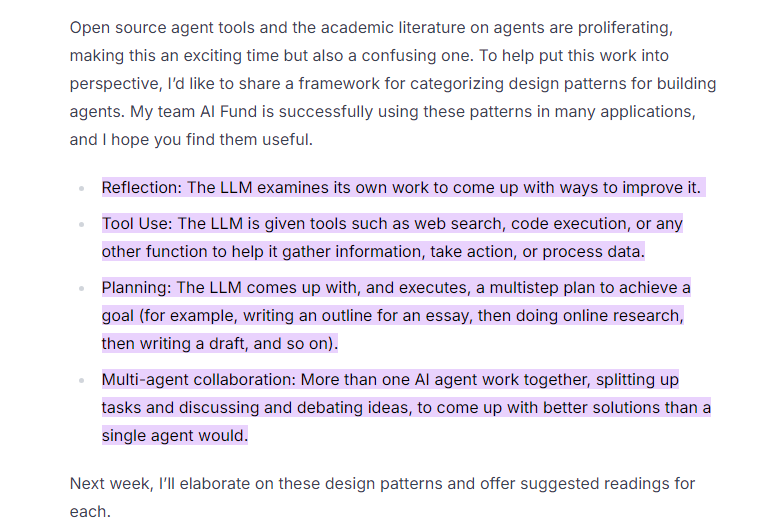